# Task 5. Audio processing. [10 pts]

<span style="color:red">__All cells of the notebook should work without errors when run consecutively.__</span>

Before starting the assignment, make this notebook `Trusted` for valid display of images:

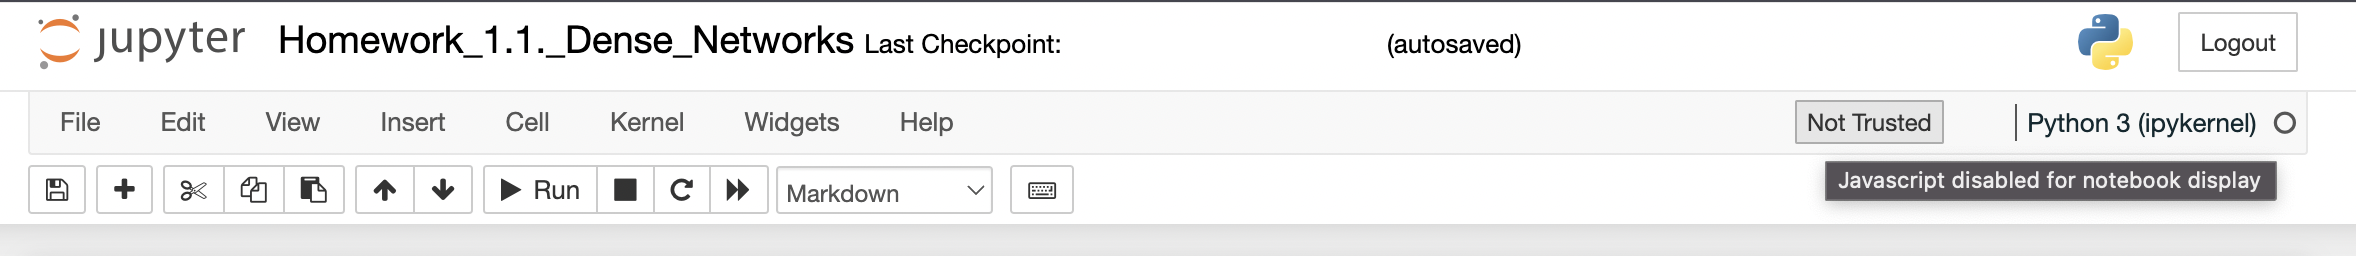

In this assignment, we will train several neural network architectures for audio classification task. We will use Mel Spectrograms as audio representations and consider transformers, 1D and 2D encoders as backbone feature extractors.

Let's start with downloading the data. We will use [ESC-50](https://github.com/karoldvl/ESC-50/) &mdash; a dataset for Environmental Sound Classification, which has 50 classes in total.

In [1]:
%%bash
wget https://github.com/karoldvl/ESC-50/archive/master.zip
unzip master.zip

--2024-11-06 20:26:55--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2024-11-06 20:26:55--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2024-11-06 20:26:55--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

     0K .......... .........

Archive:  master.zip
33c8ce9eb2cf0b1c2f8bcf322eb349b6be34dbb6
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-master/.circleci/config.yml  
   creating: ESC-50-master/.github/
  inflating: ESC-50-master/.github/stale.yml  
 extracting: ESC-50-master/.gitignore  
  inflating: ESC-50-master/LICENSE   
  inflating: ESC-50-master/README.md  
   creating: ESC-50-master/audio/
  inflating: ESC-50-master/audio/1-100032-A-0.wav  
  inflating: ESC-50-master/audio/1-100038-A-14.wav  
  inflating: ESC-50-master/audio/1-100210-A-36.wav  
  inflating: ESC-50-master/audio/1-100210-B-36.wav  
  inflating: ESC-50-master/audio/1-101296-A-19.wav  
  inflating: ESC-50-master/audio/1-101296-B-19.wav  
  inflating: ESC-50-master/audio/1-101336-A-30.wav  
  inflating: ESC-50-master/audio/1-101404-A-34.wav  
  inflating: ESC-50-master/audio/1-103298-A-9.wav  
  inflating: ESC-50-master/audio/1-103995-A-30.wav  
  inflating: ESC-50-master/audio/1-103999-A-30.wav  
  infla

Now, let's import the libraries. If you are doing this assignment not in Google Colab, you'll probably need to install the `torchvision` package. Simply use pip for that:

```bash
pip install torchvision
```

In [2]:
%pip install torchaudio


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchaudio
from IPython.display import Audio

from torch import nn
from torchaudio import transforms as T
from torchvision.transforms import Compose
from tqdm.notebook import tqdm

plt.rcParams.update({"font.size": 16})


Now, we load the metadata file using as `pandas` DataFrame.

In [9]:
data_root = "ESC-50-master/audio"
df = pd.read_csv("ESC-50-master/meta/esc50.csv")
df.head()


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


This is the list of all classes included in the dataset. As you can see, the classes are quite different, including both natural and mechanistic sounds.

In [10]:
df.category.unique()


array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

## Task 0.1. Pre-processing data [0.5 pts]

The following cell takes one random recording from the dataset and displays it as audio. You can play around with this cell and listen to different recordings. Note that all audios in this dataset have fixed length of 5 seconds.

In [11]:
rand_row = df.sample(1).iloc[0]
audio, orig_sample_rate = torchaudio.load(os.path.join(data_root, rand_row.filename))

print(f"Filename: {rand_row.filename}")
print(f"Sample rate: {orig_sample_rate}")
print(f"Class id: {rand_row.target}")
print(f"Class name: {rand_row.category}")
print(f"Duration: {audio.shape[-1] / orig_sample_rate:.2f}s")
print(f"Audio array shape: {audio.shape}")

Audio(audio, rate=orig_sample_rate)


Filename: 5-160614-H-48.wav
Sample rate: 44100
Class id: 48
Class name: fireworks
Duration: 5.00s
Audio array shape: torch.Size([1, 220500])


Moreover, all the audios of the dataset have the value of sample rate equal to 44100. [Sample rate](https://en.wikipedia.org/wiki/Sampling_(signal_processing)) is the quantity of float numbers stored for each second of the recording. Such a high value of sample rate is unnecessary for training deep learning models. The lower value of sample rate, the faster the processing. Therefore, we will manually resample our audios to sample rate  16000 (which is quite common for audio processing neural networks). We will use the `torchaudio.transform.Resample` object for this purpose.

In [12]:
sample_rate = 16000
resampler = T.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)
resampled_audio = resampler(audio)


Various spectrograms are a common tool for representing 1D audio signal as a 2D matrix. The first dimension of a spectrogram corresponds to different frequencies, while the second dimension denotes time. We will use [Mel Spectrograms](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53), which have logarithmic scale of frequencies (they are thought to represent human's perception of audio signals better). The spectrogram represents some non-negative amplitude values, which have different magnitude orders, and thus we will apply logarithm to the spectrogram (we will also add a small addition of $10^{-9}$ to prevent taking the logarithm of zero). The `n_mels` parameter of the spectrogram controls the number of frequencies to compute (i.e., the number of features for each timestep of the spectrogram).

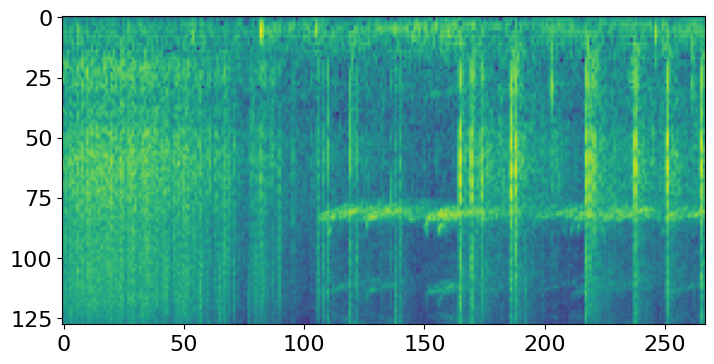

In [13]:
spectrogramer = T.MelSpectrogram(sample_rate=sample_rate, n_mels=128, n_fft=600)
spec = spectrogramer(resampled_audio)[0]

plt.figure(figsize=(12, 4))
plt.imshow(torch.log(spec + 1e-9))
plt.show()


Now, we split the data into training, validation and testing subsets. We will use a stratified split so that each of three subsets has equal ratio of 50 classes and 5 folds (different sources of data used when collecting the dataset).

In [14]:
from sklearn.model_selection import train_test_split

stratify = df.fold * 100 + df.target
train_df, test_df = train_test_split(
    df, test_size=0.25, stratify=stratify, random_state=0
)
valid_stratify = train_df.fold * 100 + train_df.target
train_df, valid_df = train_test_split(
    train_df, test_size=1 / 6, stratify=valid_stratify, random_state=0
)

train_df.shape, valid_df.shape, test_df.shape


((1250, 7), (250, 7), (500, 7))

Your task is to implement the `process_file` function. It takes the audio filename as input and applied the following processing pipeline:

1. Load the audio from the disk.
2. Resample the audio to sample rate 16000
3. Compute Mel Spectrogram of audio and apply the logarithm (add the `eps` value inside the logarithm).

**Importantly**, your output tensor should be 2D, having the shape **(n_mels, timesteps)**, so you need to remove the redundant dimension.

In [15]:
def process_file(filename, eps=1e-9):
    """
    Process audio file
    :param  filename: path to .wav file
    :param       eps: value to stabilize logarithm computation
    :return: logarithm of spectrogram of shape (n_mels, timesteps)
    """
    audio, orig_sample_rate = torchaudio.load(filename)
    resampler = T.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)
    resampled_audio = resampler(audio)
    spectrogramer = T.MelSpectrogram(sample_rate=sample_rate, n_mels=128, n_fft=600)
    spec = spectrogramer(resampled_audio)[0]
    return torch.log(spec + eps)


def process_df(df):
    y = torch.tensor(df.target.tolist())
    X = torch.stack(
        [
            process_file(os.path.join(data_root, row.filename))
            for _, row in tqdm(df.iterrows(), total=df.shape[0])
        ],
        dim=0,
    )
    return X, y


Now, apply the processing function to all three dataframes.

In [16]:
X_train, y_train = process_df(train_df)
X_valid, y_valid = process_df(valid_df)
X_test, y_test = process_df(test_df)


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Finally, you need to initialize training, validation and testing datasets (use `TensorDataset`) and define the dataloders.

In [17]:
from torch.utils.data import DataLoader, TensorDataset

train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)
test_set = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Task 0.2. Implementing training loop [1 pts]

Now, implement the functions for training and evaluating the networks. Store loss and accuracy values for training and validation subsets for each epoch to plot the values during training.

- You can calculate loss and accuracy values for training set during training (i.e., no need to call `calculate_metrics` for the train dataloader at the end of epoch)
- `transform` in `train_model` is an augmentation function to use during training. This will come in handy in Task 4.
- Do not forget to make the step of `scheduler` at the end of epoch!

In [45]:
import copy

from IPython.display import clear_output, display
from tqdm.auto import tqdm


@torch.no_grad()
def calculate_metrics(model, dataloader):
    """
    Calculate accuracy and loss over a dataloader
    :param       model: the model to use for predictions
    :param   dataloder: the dataloder to evaluate metrics on
    :return: loss, accuracy
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for data, labels in dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        outputs = model(data)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * data.size(0)
        total_correct += (outputs.argmax(dim=1) == labels).float().sum().item()
        total_samples += data.size(0)
    return total_loss / total_samples, total_correct / total_samples


def plot_losses(
    train_loss_values, valid_loss_values, train_acc_values, valid_acc_values
):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(range(1, len(train_loss_values) + 1), train_loss_values, label="train")
    axs[0].plot(range(1, len(valid_loss_values) + 1), valid_loss_values, label="valid")
    axs[1].plot(range(1, len(train_acc_values) + 1), train_acc_values, label="train")
    axs[1].plot(range(1, len(valid_acc_values) + 1), valid_acc_values, label="valid")
    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("accuracy")

    for ax in axs:
        ax.grid()
        ax.legend()
        ax.set_xlabel("epoch")

    plt.show()


# Adding some tricks, because otherwise I don't get needed validation accuracy :(
def train_model(
    train_loader,
    valid_loader,
    model,
    epochs,
    lr,
    transform=None,
    take_profit=None,
    flooding=0.0,
):
    """
    :param     train_loader: the training dataloader
    :param     valid_loader: the validation dataloader
    :param            model: the model to train
    :param           epochs: the number of training epoch
    :param               lr: the value of learning rate used in optimizer
    :param        transform: the augmentation function to use during training
    :param     take_profit: accuracy threshold on validation to stop training early
    """
    train_loss_values, valid_loss_values = [], []
    train_acc_values, valid_acc_values = [], []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Initialize EMA model
    ema_model = copy.deepcopy(model)
    ema_decay = 0.9

    def update_ema_model():
        with torch.no_grad():
            for ema_param, model_param in zip(
                ema_model.parameters(), model.parameters()
            ):
                ema_param.data.mul_(ema_decay).add_(
                    model_param.data, alpha=1 - ema_decay
                )

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}")
        ### TRAINING ###
        model.train()

        current_losses, current_accs = [], []
        for data, labels in tqdm(train_loader, total=len(train_loader)):
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            if transform is not None:
                data = transform(data)

            outputs = model(data)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            (loss - flooding).abs().backward()
            optimizer.step()

            # Update EMA model
            update_ema_model()

            current_losses.append(loss.item())
            current_accs.append(
                (outputs.argmax(dim=1) == labels).float().sum().item() / data.size(0)
            )

        train_loss_values.append(sum(current_losses) / len(current_losses))
        train_acc_values.append(sum(current_accs) / len(current_accs))
        print(
            f"Train loss: {train_loss_values[-1]:.4f}, Train acc: {train_acc_values[-1]:.4f}"
        )

        ### VALIDATING ###
        # Store current model state
        current_model_state = copy.deepcopy(model.state_dict())
        # Load EMA weights for validation
        model.load_state_dict(ema_model.state_dict())

        valid_loss, valid_acc = calculate_metrics(model, valid_loader)
        valid_loss_values.append(valid_loss)
        valid_acc_values.append(valid_acc)
        print(
            f"Valid loss: {valid_loss_values[-1]:.4f}, Valid acc: {valid_acc_values[-1]:.4f}"
        )

        # Restore original weights
        model.load_state_dict(current_model_state)

        if epoch % 5 == 0:
            plot_losses(
                train_loss_values, valid_loss_values, train_acc_values, valid_acc_values
            )

        # Check take profit condition
        if take_profit is not None and valid_acc >= take_profit:
            print(
                f"Reached target validation accuracy of {take_profit}. Stopping training."
            )
            break

    # Load EMA weights as final weights
    model.load_state_dict(ema_model.state_dict())
    torch.cuda.empty_cache()


def get_num_params(model):
    return sum(param.numel() for param in model.parameters())


def evaluate_model(classifier, model_name=None, eval_df=None):
    if eval_df is None:
        eval_df = pd.DataFrame(
            columns=[
                "Model",
                "Params Number",
                "Train Accuracy",
                "Validation Accuracy",
                "Test Accuracy",
            ]
        )

    if model_name is None:
        model_name = classifier.__class__.__name__

    _, train_accuracy = calculate_metrics(classifier, train_loader)
    _, validation_accuracy = calculate_metrics(classifier, valid_loader)
    _, test_accuracy = calculate_metrics(classifier, test_loader)
    num_params = get_num_params(classifier)

    eval_df = pd.concat(
        [
            eval_df,
            pd.DataFrame(
                [
                    {
                        "Model": model_name,
                        "Params Number": num_params,
                        "Train Accuracy": train_accuracy,
                        "Test Accuracy": test_accuracy,
                        "Validation Accuracy": validation_accuracy,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

    display(eval_df)
    return eval_df


## Task 1. Attention Classifier [2.5 pts]

We will start our experiments with transformer-like model. Use several (`n_layers`) consecutive layers of `nn.TransformerEncoderLayer` as a backbone. Then, take the resulting representations outputted by transformer layers and average them over the length dimension (i.e., Global Average Pooling). Finally, use a linear classification head. The dimensionality of encoder layers should be the same as `n_mels`, as we treat our spectrogram as a sequence of feature vectors (i.e., each feature is a frequency).

In [46]:
class AttentionClassifier(nn.Module):
    def __init__(self, n_layers=1, d_model=128, dim_feedforward=2048, nhead=16):
        """
        Model based on nn.TransformerEncoderLayer
        :param         n_layers: number of nn.TransformerEncoderLayer layers
        :param          d_model: number of spectrogram features (n_mels)
        :param  dim_feedforward: the corresponding parameter for nn.TransformerEncoderLayer
        :param           n_head: the corresponding parameter for nn.TransformerEncoderLayer
        """
        super(AttentionClassifier, self).__init__()
        self.n_classes = 50
        self.transformer_layers = nn.ModuleList(
            [
                nn.TransformerEncoderLayer(
                    d_model=d_model,
                    nhead=nhead,
                    dim_feedforward=dim_feedforward,
                    batch_first=True,
                )
                for _ in range(n_layers)
            ]
        )
        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, self.n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        for layer in self.transformer_layers:
            x = layer(x)
            x = self.norm(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x


Initialize the `AttentionClassifier` with default parameters. Feel free to use the validation set to find appropriate values of `epochs` and `lr` (i.e., we do not ask you to launch the full grid search for these hyperparameters, just play around and find the values performing good).

In [47]:
classifier = AttentionClassifier()
print(f"{classifier.__class__.__name__} has {get_num_params(classifier)} parameters")

if torch.cuda.is_available():
    classifier = classifier.cuda()


AttentionClassifier has 599730 parameters


In [44]:
train_model(
    train_loader,
    valid_loader,
    classifier,
    epochs=100,
    lr=2e-3,
    take_profit=0.6,
    flooding=3.0,
)


Epoch 1


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 3.5340, Train acc: 0.1008
Valid loss: 3.0310, Valid acc: 0.1640
Epoch 2


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 3.1426, Train acc: 0.1320
Valid loss: 2.9908, Valid acc: 0.1520
Epoch 3


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 3.1758, Train acc: 0.1336
Valid loss: 3.0557, Valid acc: 0.1120
Epoch 4


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 3.0775, Train acc: 0.1258
Valid loss: 3.0809, Valid acc: 0.1240
Epoch 5


  0%|          | 0/40 [00:00<?, ?it/s]

In [73]:
eval_df = evaluate_model(classifier, eval_df=None)


/var/folders/sm/c_cj474n2sngck2h4fsn34gw0000gn/T/ipykernel_67126/3043851768.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


,Model,Params Number,Train Accuracy,Validation Accuracy,Test Accuracy
0,AttentionClassifier,599730,0.996,0.572,0.538


If you have done everything right, you'll have the test accuracy $\approx 60\%$.

## Task 2. 1D Convolutional Encoder [2.5 pts]

The next step is to try convolutional backbones. We will start with 1D convolutions, which are popular for audio processing. We will treat the frequencies as the channels dimensionality and apply the 1D convolutions over the time dimensionality.

First of all, you need to implement a `ResBlock1D`, similar to blocks of regular ResNet. The scheme of block is presented in the image below. The block takes a features map having `in_channels` channels, each convolution has `out_channels` number of output channels. The convolution parameters are shown in the image.

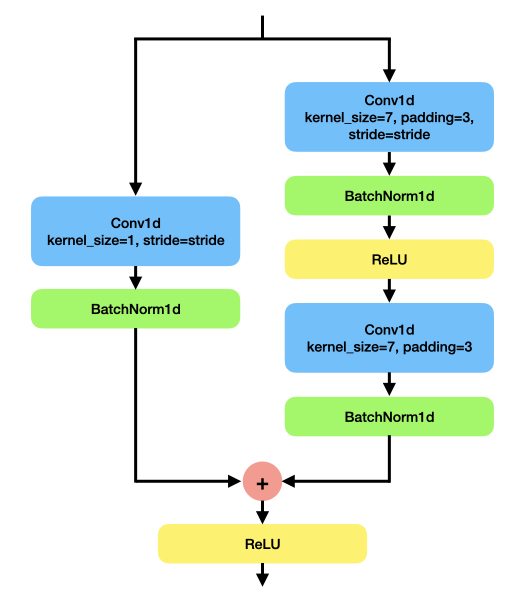

Once the `ResBlock1D` is implemented, we can assembly the whole network. It will consist of 4 sequential blocks. We will make the width of the network variable using the `width_factor` parameter:

1. `in_channels=128` (equal to `n_mels`), `out_channels=width_factor`, `stride=2`
2. `in_channels=width_factor`, `out_channels=width_factor * 2`, `stride=2`
3. `in_channels=width_factor * 2`, `out_channels=width_factor * 4`, `stride=2`
4. `in_channels=width_factor * 4`, `out_channels=width_factor * 8`, `stride=2`

Then, average the resulting feature maps over the time dimension (Global Average Pooling) and apply the linear classification layer.

**Important!** Do not forget to set `bias=False` for convolutions before the batch normalization layers, as the bias will be useless because of the normalization operation.

In [92]:
class ResBlock1D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock1D, self).__init__()
        self.c1 = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, stride=stride, bias=False
        )
        self.c71 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=7,
            stride=stride,
            padding=3,
            bias=False,
        )
        self.c72 = nn.Conv1d(
            out_channels, out_channels, kernel_size=7, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn71 = nn.BatchNorm1d(out_channels)
        self.bn72 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        left = self.bn1(self.c1(x))
        right = self.bn72(self.c72(self.relu(self.bn71(self.c71(x)))))
        return left + right


class CNNClassifier1D(torch.nn.Module):
    def __init__(self, in_channels=128, width_factor=16):
        super(CNNClassifier1D, self).__init__()
        n_classes = 50
        self.b1 = ResBlock1D(in_channels=128, out_channels=width_factor, stride=2)
        self.b2 = ResBlock1D(
            in_channels=width_factor, out_channels=width_factor * 2, stride=2
        )
        self.b3 = ResBlock1D(
            in_channels=width_factor * 2, out_channels=width_factor * 4, stride=2
        )
        self.b4 = ResBlock1D(
            in_channels=width_factor * 4, out_channels=width_factor * 8, stride=2
        )
        self.fc = nn.Linear(width_factor * 8, n_classes)

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = x.mean(dim=2)
        x = self.fc(x)
        return x


We want a fair comparison of different architectures, so we will try to keep the same number of parameters as we had in `AttentionClassifier`. Find such value of `width_factor` so that the difference in number of parameters is less then $10\%$.

In [93]:
classifier = CNNClassifier1D(width_factor=25)
print(f"{classifier.__class__.__name__} has {get_num_params(classifier)} parameters")

if torch.cuda.is_available():
    classifier = classifier.cuda()


CNNClassifier1D has 619775 parameters


And again, feel free to tune the `epochs` and `lr` using the validation set.

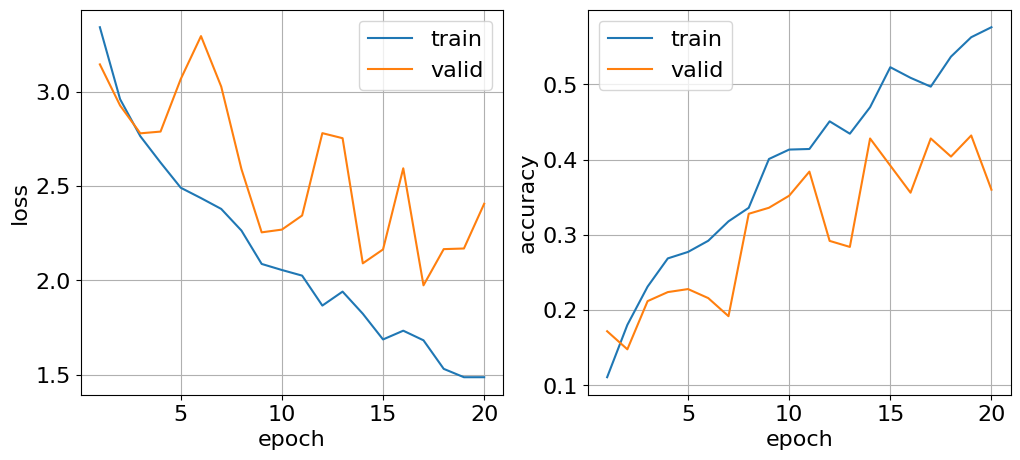

In [94]:
train_model(train_loader, valid_loader, classifier, epochs=20, lr=1e-3)


In [ ]:
eval_df = evaluate_model(classifier, eval_df=eval_df)


If you have done everything right, you'll have the test accuracy $\approx 60 \%$.

## Task 3. 2D Convolutional Encoder [2.5 pts]

Finally, we will treat our spectrograms as images, which have one color channel, and use 2D convolutions to process them. Take the convolutional architecture from the previous part and replace $1\times 7$ convolutions with $3\times 3$ convolutions (but keep the $1\times 1$ convolutions in the residual connection as is). Also set `padding=1` for $3\times 3$ convolutions. Do not forget to switch `nn.BatchNorm1d` to `nn.BatchNorm2d`.

**Important!** We will treat spectrograms as images having one color channel, so don't forget to add this channels, i.e., you will need to resize `(batch_size, n_mels, timesteps)` tensor to `(batch_size, 1, n_mels, timesteps)`.

In [20]:
""" 
class ResBlock1D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock1D, self).__init__()
        self.c1 = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, stride=stride, bias=False
        )
        self.c71 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=7,
            stride=stride,
            padding=3,
            bias=False,
        )
        self.c72 = nn.Conv1d(
            out_channels, out_channels, kernel_size=7, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn71 = nn.BatchNorm1d(out_channels)
        self.bn72 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        left = self.bn1(self.c1(x))
        right = self.bn72(self.c72(self.relu(self.bn71(self.c71(x)))))
        return left + right


class CNNClassifier1D(torch.nn.Module):
    def __init__(self, in_channels=128, width_factor=16):
        super(CNNClassifier1D, self).__init__()
        n_classes = 50
        self.b1 = ResBlock1D(in_channels=128, out_channels=width_factor, stride=2)
        self.b2 = ResBlock1D(
            in_channels=width_factor, out_channels=width_factor * 2, stride=2
        )
        self.b3 = ResBlock1D(
            in_channels=width_factor * 2, out_channels=width_factor * 4, stride=2
        )
        self.b4 = ResBlock1D(
            in_channels=width_factor * 4, out_channels=width_factor * 8, stride=2
        )
        self.fc = nn.Linear(width_factor * 8, n_classes)

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = x.mean(dim=2)
        x = self.fc(x)
        return x

"""


class ResBlock2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock2D, self).__init__()
        self.c1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=stride, bias=False
        )
        self.c31 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.c32 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn31 = nn.BatchNorm2d(out_channels)
        self.bn32 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        left = self.bn1(self.c1(x))
        right = self.bn32(self.c32(self.relu(self.bn31(self.c31(x)))))
        return left + right


class CNNClassifier2D(torch.nn.Module):
    def __init__(self, width_factor=16):
        super(CNNClassifier2D, self).__init__()
        n_classes = 50
        self.b1 = ResBlock2D(in_channels=1, out_channels=width_factor, stride=2)
        self.b2 = ResBlock2D(
            in_channels=width_factor, out_channels=width_factor * 2, stride=2
        )
        self.b3 = ResBlock2D(
            in_channels=width_factor * 2, out_channels=width_factor * 4, stride=2
        )
        self.b4 = ResBlock2D(
            in_channels=width_factor * 4, out_channels=width_factor * 8, stride=2
        )
        self.fc = nn.Linear(width_factor * 8, n_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = x.mean(dim=(2, 3))
        x = self.fc(x)
        return x


Again, find such value of `width_factor` so that the difference to `AttentionClassifier` in number of parameters is less then $10\%$.

In [28]:
classifier = CNNClassifier2D(width_factor=22)
print(f"{classifier.__class__.__name__} has {get_num_params(classifier)} parameters")

if torch.cuda.is_available():
    classifier = classifier.cuda()


CNNClassifier2D has 584590 parameters


And again, feel free to tune the `epochs` and `lr` using the validation set.

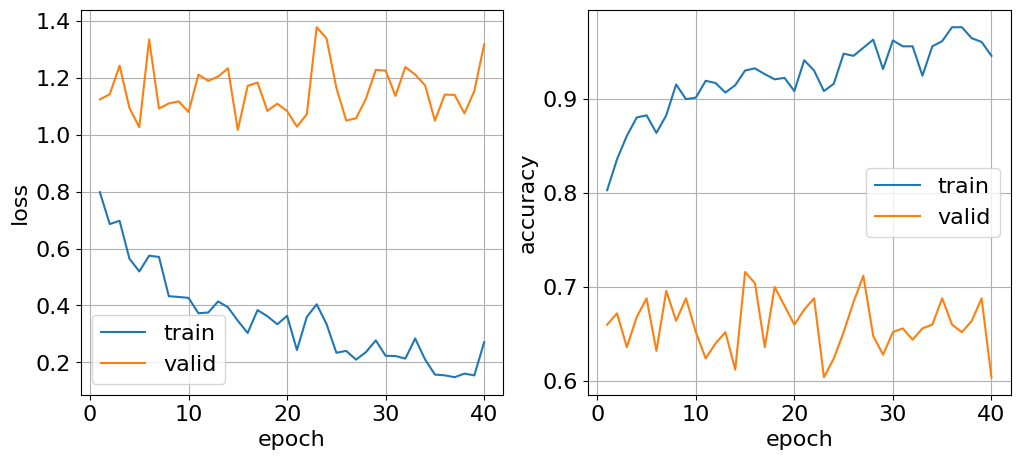

In [30]:
train_model(train_loader, valid_loader, classifier, epochs=40, lr=5e-4)


In [ ]:
eval_df = evaluate_model(classifier, eval_df=eval_df)


If you have done everything right, you'll have the test accuracy $\ge 72 \%$.

## Task 4. Adding augmentations [1 pts]

One final step is to add augmentations to spectrograms to make the network more robust and improve the test quality. We will use two types of augmentations: [`torchvision.transforms.FrequencyMasking`](https://pytorch.org/audio/stable/generated/torchaudio.transforms.FrequencyMasking.html#torchaudio.transforms.FrequencyMasking) and [`torchvision.transforms.TimeMasking`,](https://pytorch.org/audio/stable/generated/torchaudio.transforms.TimeMasking.html#torchaudio.transforms.TimeMasking) which mask out horizontal and vertical regions of the spectrogram. Take the best performing architecture (should be `CNNClassifier2D`) and use the validation set to find the best parameters for these augmentations. Then, train the final model.

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.FrequencyMasking(freq_mask_param=15),
        transforms.TimeMasking(time_mask_param=35),
    ]
)


In [ ]:
classifier = CNNClassifier2D(width_factor=22)
print(f"{classifier.__class__.__name__} has {get_num_params(classifier)} parameters")

if torch.cuda.is_available():
    classifier = classifier.cuda()


In [ ]:
train_model(
    train_loader, valid_loader, classifier, epochs=..., lr=..., transform=transform
)


In [ ]:
eval_df = evaluate_model(
    classifier, model_name="CNNClassifier2D + aug", eval_df=eval_df
)


If you have done everything right, you'll have the test accuracy $\ge 76 \%$.